In [1]:
import numpy as np
import pandas as pd

import time

from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import albumentations as albu
from albumentations.pytorch import ToTensor

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms.functional as TF
from torch import nn
import torch.nn.functional as F
from torch.utils.data import SubsetRandomSampler
from torch.optim import Adam,lr_scheduler

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from tqdm import tqdm_notebook, tqdm

from glob import glob

import cv2

import os

import shutil

In [2]:
torch.cuda.is_available()

True

In [3]:
TRAIN_DIR = './global-wheat-detection/train/'

In [4]:
train_labels = pd.read_csv('./global-wheat-detection/train.csv')

In [5]:
train_labels.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [6]:
train_fns = glob('./global-wheat-detection/train/' + '*')

# Create a dataframe with all train images
all_train_images = pd.DataFrame([fns.split('/')[-1][:-4] for fns in train_fns])
all_train_images.columns=['image_id']

# Merge all train images with the bounding boxes dataframe
all_train_images = all_train_images.merge(train_labels, on='image_id', how='left')

# replace nan values with zeros
all_train_images['bbox'] = all_train_images.bbox.fillna('[0,0,0,0]')

# split bbox column
bbox_items = all_train_images.bbox.str.split(',', expand=True)
all_train_images['bbox_xmin'] = bbox_items[0].str.strip('[ ').astype(float)
all_train_images['bbox_ymin'] = bbox_items[1].str.strip(' ').astype(float)
all_train_images['bbox_width'] = bbox_items[2].str.strip(' ').astype(float)
all_train_images['bbox_height'] = bbox_items[3].str.strip(' ]').astype(float)

In [7]:
all_train_images['bbox_area'] = all_train_images['bbox_width'] * all_train_images['bbox_height']

In [8]:
max_area_threshold = 100000
min_area_threshold = 50

In [9]:
train_labels_cleaned = all_train_images[((all_train_images.bbox_area < max_area_threshold) & (all_train_images.bbox_area > min_area_threshold)) | (all_train_images.bbox_area == 0)]

In [10]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [12]:
device

device(type='cuda', index=0)

In [13]:
train_transforms_example = albu.Compose([
    albu.RandomSizedBBoxSafeCrop(512, 512, erosion_rate=0.0, interpolation=1, p=1.0),
    albu.HorizontalFlip(p=0.5),
    albu.VerticalFlip(p=0.5),
    albu.OneOf([albu.RandomContrast(),
                albu.RandomGamma(),
                albu.RandomBrightness()], p=0.5),
    albu.CLAHE(p=1.0)], p=1.0, bbox_params=albu.BboxParams(format='coco', label_fields=['category_id']))

In [14]:
def apply_transforms(transforms, df, n_transforms=3):
    idx = np.random.randint(len(df), size=1)[0]
    
    image_id = df.iloc[idx].image_id
    bboxes = []
    for _, row in df[df.image_id == image_id].iterrows():
        bboxes.append([row.bbox_xmin, row.bbox_ymin, row.bbox_width, row.bbox_height])
        
    image = Image.open(TRAIN_DIR + image_id + '.jpg')
    
    fig, axs = plt.subplots(1, n_transforms+1, figsize=(15,7))
    
    # plot the original image
    axs[0].imshow(image)
    axs[0].set_title('original')
    for bbox in bboxes:
        rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=1,edgecolor='r',facecolor='none')
        axs[0].add_patch(rect)
    
    # apply transforms n_transforms times
    for i in range(n_transforms):
        params = {'image': np.asarray(image),
                  'bboxes': bboxes,
                  'category_id': [1 for j in range(len(bboxes))]}
        augmented_boxes = transforms(**params)
        bboxes_aug = augmented_boxes['bboxes']
        image_aug = augmented_boxes['image']

        # plot the augmented image and augmented bounding boxes
        axs[i+1].imshow(image_aug)
        axs[i+1].set_title('augmented_' + str(i+1))
        for bbox in bboxes_aug:
            rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=1,edgecolor='r',facecolor='none')
            axs[i+1].add_patch(rect)
    plt.show()

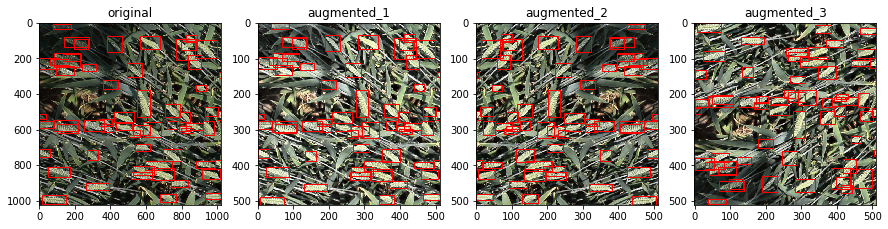

In [15]:
apply_transforms(train_transforms_example, all_train_images, n_transforms=3)

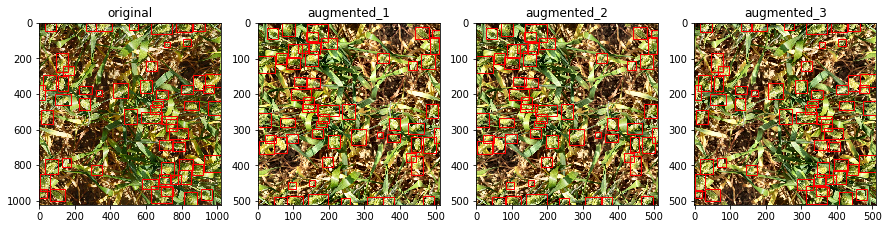

In [16]:
apply_transforms(train_transforms_example, all_train_images, n_transforms=3)

In [17]:
train_transforms = albu.Compose([
    albu.RandomSizedBBoxSafeCrop(256, 256, erosion_rate=0.0, interpolation=1, p=1.0),
    albu.HorizontalFlip(p=0.5),
    albu.VerticalFlip(p=0.5),
    albu.OneOf([albu.RandomContrast(),
                albu.RandomGamma(),
                albu.RandomBrightness()], p=0.5),
    albu.CLAHE(p=1.0),
    ToTensor()
    ], p=1.0, bbox_params=albu.BboxParams(format='coco', label_fields=['labels']))

test_transforms = albu.Compose([
    albu.RandomSizedBBoxSafeCrop(512, 512, erosion_rate=0.0, interpolation=1, p=1.0),
    albu.CLAHE(p=1.0),
    ToTensor()
    ], p=1.0, bbox_params=albu.BboxParams(format='coco', label_fields=['labels']))

In [18]:
all_train_images.head(1)

,image_id,width,height,bbox,source,bbox_xmin,bbox_ymin,bbox_width,bbox_height,bbox_area
0,ad62f80f2,1024.0,1024.0,"[335.0, 826.0, 148.0, 103.0]",arvalis_3,335.0,826.0,148.0,103.0,15244.0


In [19]:
class Wheatset(Dataset):
    def __init__(self,data_frame,image_dir,phase='train'):
        super().__init__()
        self.df = data_frame
        self.image_dir = image_dir
        self.images = data_frame['image_id'].unique()
        
        if phase == 'train':
            self.transforms = train_transforms
        else:
            self.transforms = test_transforms
        
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,idx):
        image = self.images[idx] + '.jpg'
        image_arr = cv2.imread(os.path.join(self.image_dir,image), cv2.IMREAD_COLOR)
        image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB).astype(np.uint8)
        #image_arr /= 255.0
        image_id = str(image.split('.')[0])
        point = self.df[self.df['image_id'] == image_id]
        boxes = point[['bbox_xmin', 'bbox_ymin', 'bbox_width', 'bbox_height']].values
        #boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        #boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        #area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = (boxes[:, 3]) * (boxes[:, 2])
        area = torch.as_tensor(area, dtype=torch.float32)
        
        # there is only one class
        labels = torch.ones((point.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((point.shape[0],), dtype=torch.int32)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        #target['image_id'] = torch.tensor(idx)
        #target['area'] = area
        #target['iscrowd'] = iscrowd
        
        if self.transforms:
            sample = {
                'image': image_arr,
                'bboxes': target['boxes'],
                'labels': target['labels']
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
        target['boxes'] = torch.stack(tuple(map(torch.tensor, 
                                                zip(*sample['bboxes'])))).permute(1, 0)
        
        return image, target, image_id

In [20]:
train_img = all_train_images[all_train_images.bbox_width > 0]

In [21]:
train_split = 0.8

image_ids = train_img['image_id'].unique()
train_ids = image_ids[0:int(train_split*len(image_ids))]
val_ids = image_ids[int(train_split*len(image_ids)):]


train_df = train_img[train_img['image_id'].isin(train_ids)]
val_df = train_img[train_img['image_id'].isin(val_ids)]

train_data = Wheatset(train_df,TRAIN_DIR,phase='train')
val_data = Wheatset(val_df,TRAIN_DIR,phase='validation')

print(f'Length of train data {len(train_data)}')
print(f'Length of validation data {len(val_data)}')

Length of train data 2698
Length of validation data 675


In [22]:
# batching
def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader = DataLoader(
    train_data,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    val_data,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

In [23]:
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    image = (image * 255).astype(np.uint8)
    image = (image).astype(np.uint8)
    return image

def plot_img(data,idx):
    out = data.__getitem__(idx)
    image = image_convert(out[0])
    image = np.ascontiguousarray(image)
    
    fig, ax = plt.subplots(figsize=(5,5))

    bb = out[1]['boxes'].numpy()
    
    for bbox in bb:
        rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=2,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    
    ax.imshow(image)
    plt.show()

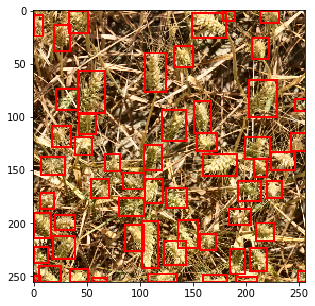

In [24]:
plot_img(train_data,101)

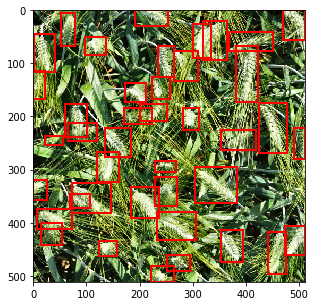

In [25]:
plot_img(val_data,5)

In [26]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [27]:
images, targets, ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [28]:
device

device(type='cuda', index=0)

In [29]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

In [30]:
model = model.double()

In [31]:
train_stats = pd.DataFrame(columns = ['Epoch', 'Time per epoch', 'Avg time per step', 'Train loss'
                                      ,'Test loss'])

In [32]:
# set optimizer, only train the classifier parameters, feature parameters are frozen
learning_rate = 0.001
optimizer = Adam(model.parameters(), lr=learning_rate)
epochs = 1

In [ ]:
steps = 0
running_loss = 0
model.train()
for epoch in range(epochs):
    
    since = time.time()
    
    train_accuracy = 0
    top3_train_accuracy = 0 
    for images, targets, image_ids in tqdm_notebook(train_data_loader):
        steps += 1
        # Move input and label tensors to the default device
        images = list(image.to(device) for image in images)
        images = [image.double() for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

    time_elapsed = time.time() - since
    
    test_loss = 0
    #model.eval()
    with torch.no_grad():
        for images, targets, image_ids in tqdm_notebook(valid_data_loader):
            images = list(image.to(device) for image in images)
            images = [image.double() for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            test_loss += losses.item()
            
    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Time per epoch: {time_elapsed:.4f}.. "
          f"Average time per step: {time_elapsed/len(train_data_loader):.4f}.. "
          f"Train loss: {running_loss/len(train_data_loader):.4f}.. "
          f"Test loss: {test_loss/len(valid_data_loader):.4f}.. ")

    train_stats = train_stats.append({'Epoch': epoch, 'Time per epoch':time_elapsed,
                                      'Avg time per step': time_elapsed/len(train_data_loader),
                                      'Train loss' : running_loss/len(train_data_loader),
                                      'Test loss' : test_loss/len(valid_data_loader)}, ignore_index=True)
    
    # save the checkpoint
    filename = 'faster-rcnn_'+ str(epochs) + '.pth'
    checkpoint = {'state_dict': model.state_dict()}
    torch.save(checkpoint, filename)

    running_loss = 0
    steps = 0
    model.train()

<ipython-input-47-41f243af5605>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for images, targets, image_ids in tqdm_notebook(train_data_loader):


In [ ]:
train_stats.to_csv('train_stats_{}.csv'.format(epochs))

In [ ]:
plt.plot(train_stats['Train loss'], label='train')
plt.plot(train_stats['Test loss'], label='test')
plt.title('Loss over epoch')
plt.legend()
plt.show()